# Multiclass Text Classification using LSTM architecture
(Runs best on a TPU)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')

In [2]:
df = pd.read_csv('drive/MyDrive/Multiclass Text Classification/intent.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6679 entries, 0 to 6678
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   motivos  6679 non-null   object 
 1   crec     6679 non-null   int64  
 2   cred     6679 non-null   int64  
 3   equ      6679 non-null   int64  
 4   inic     6679 non-null   int64  
 5   inv      6679 non-null   int64  
 6   mkt      6679 non-null   int64  
 7   no       6679 non-null   int64  
 8   renta    6679 non-null   int64  
 9   sueldo   6679 non-null   int64  
 10  temp     6673 non-null   float64
dtypes: float64(1), int64(9), object(1)
memory usage: 574.1+ KB


In [3]:
df['temp'].fillna(df['temp'].median(), inplace=True)
df.isna().sum()

motivos    0
crec       0
cred       0
equ        0
inic       0
inv        0
mkt        0
no         0
renta      0
sueldo     0
temp       0
dtype: int64

In [4]:
df = df.astype({"temp":'int'}) 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6679 entries, 0 to 6678
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   motivos  6679 non-null   object
 1   crec     6679 non-null   int64 
 2   cred     6679 non-null   int64 
 3   equ      6679 non-null   int64 
 4   inic     6679 non-null   int64 
 5   inv      6679 non-null   int64 
 6   mkt      6679 non-null   int64 
 7   no       6679 non-null   int64 
 8   renta    6679 non-null   int64 
 9   sueldo   6679 non-null   int64 
 10  temp     6679 non-null   int64 
dtypes: int64(10), object(1)
memory usage: 574.1+ KB


In [5]:
df['category'] = df.drop(['motivos'], axis=1).idxmax(axis=1)
df['category_id'] = df['category'].factorize()[0]
df.head()

,motivos,crec,cred,equ,inic,inv,mkt,no,renta,sueldo,temp,category,category_id
0,Crear un departamento de ventas e inversión a ...,0,0,0,0,0,1,0,0,0,0,mkt,0
1,establecerme en un local y agregar materia pri...,0,0,0,0,1,0,0,1,0,0,inv,1
2,Compra de equipo e incrementar inventario,0,0,1,0,1,0,0,0,0,0,equ,2
3,Invertir en crecimiento de flotilla de unidade...,0,0,1,0,0,0,0,0,0,0,equ,2
4,Para comprar mercancía y comprar lonas nuevas,0,0,0,0,1,0,0,0,0,0,inv,1


In [6]:
df.category.value_counts()

inv       2048
equ       1910
crec       601
renta      453
no         440
cred       422
inic       372
mkt        212
temp       142
sueldo      79
Name: category, dtype: int64

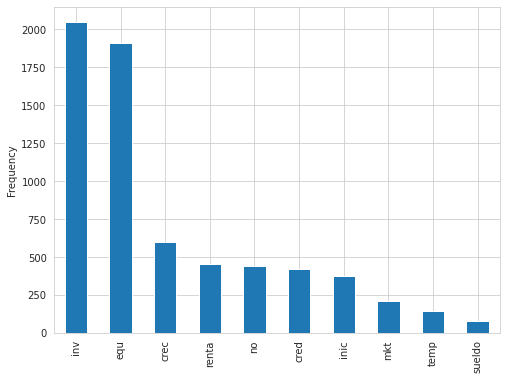

In [7]:
plt.figure(figsize=(8, 6))
df['category'].value_counts().sort_values(ascending=False).plot(kind='bar')
plt.ylabel('Frequency')
plt.show()

## Text Pre-processing

- Convert all text to lower case.
- Replace REPLACE_BY_SPACE_RE symbols by space in text.
- Remove symbols that are in BAD_SYMBOLS_RE from text.
- Remove “x” in text.
- Remove stop words.
- Remove digits in text.

In [11]:
def print_plot(index):
    example = df[df.index == index][['motivos', 'category']].values[0]
    if len(example) > 0:
        print(example[0])
        print('category:', example[1])

In [12]:
print_plot(10)
print_plot(100)

INVENTARIO PARA VENDER MUEBLES DE OFICINA
category: inv
Enganche de dos autos para aumentar flotilla de carros uber
category: equ


In [13]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
import re

df = df.reset_index(drop=True)

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('spanish'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['motivos'] = df['motivos'].apply(clean_text)
df['motivos'] = df['motivos'].str.replace('\d+', '')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
print_plot(10)
print_plot(100)
print_plot(9)
print_plot(7)

inventario vender muebles oficina
category: inv
enganche dos autos aumentar flotilla carros uber
category: equ
crdito quiero adaptar local propiedad venta formal comida
category: inic
ampliaciin negocio rentar mashabitaciones
category: crec


## LSTM Modeling

In [15]:
from keras.preprocessing.text import Tokenizer

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['motivos'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 7993 unique tokens.


Truncate and pad the input sequences so that they are all in the same length for modeling:

In [16]:
from keras.preprocessing.sequence import pad_sequences

X = tokenizer.texts_to_sequences(df['motivos'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', X.shape)

Shape of data tensor: (6679, 250)


### Converting categorical labels to numbers

In [17]:
Y = pd.get_dummies(df['category']).values
pd.DataFrame(Y).head()

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0


In [18]:
# # Y = pd.get_dummies(df['Product']).values

# Y = df.drop(['motivos', 'category', 'category_id'], axis=1)
# print('Shape of label tensor:', Y.shape)
# Y.head()

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42, stratify=Y)

print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(6011, 250) (6011, 10)
(668, 250) (668, 10)


- The first layer is the embedding layer that uses 100 length vectors to represent each word.
- SpatialDropout1D performs variational dropout in NLP models.
- The next layer is the LSTM layer with 100 memory units.
- The output layer must create 10 output values, one for each class.
- Activation function is softmax for multi-class classification.
- Because it is a multi-class classification problem, categorical_crossentropy is used as the loss function.

In [23]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.metrics import Precision, Recall

model_check = ModelCheckpoint('drive/MyDrive/Multiclass Text Classification/best_model.h5', monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=0, mode='max', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
csv_logger = CSVLogger('drive/MyDrive/Multiclass Text Classification/train_log.csv', separator=',')

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(10, activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall()])

epochs = 50
batch_size = 64
# batch_size = 32

# history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[model_check, early, reduce_lr, csv_logger])

Epoch 1/50
85/85 [==============================] - 99s 787ms/step - loss: 1.9956 - accuracy: 0.3156 - precision: 0.1062 - recall: 1.4312e-04 - val_loss: 1.8690 - val_accuracy: 0.3472 - val_precision: 0.7400 - val_recall: 0.1229
Epoch 2/50
85/85 [==============================] - 66s 776ms/step - loss: 1.5096 - accuracy: 0.5040 - precision: 0.8110 - recall: 0.2633 - val_loss: 1.3976 - val_accuracy: 0.5698 - val_precision: 0.8415 - val_recall: 0.3439
Epoch 3/50
85/85 [==============================] - 65s 767ms/step - loss: 1.0393 - accuracy: 0.6723 - precision: 0.8756 - recall: 0.5043 - val_loss: 1.2224 - val_accuracy: 0.6329 - val_precision: 0.7930 - val_recall: 0.4900
Epoch 4/50
85/85 [==============================] - 65s 768ms/step - loss: 0.7571 - accuracy: 0.7746 - precision: 0.8930 - recall: 0.6284 - val_loss: 1.1647 - val_accuracy: 0.6462 - val_precision: 0.7384 - val_recall: 0.5532
Epoch 5/50
85/85 [==============================] - 65s 765ms/step - loss: 0.5086 - accuracy: 0.

In [30]:
accr = model.evaluate(X_test,Y_test)

In [29]:
# print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

print(model.metrics_names)
print(accr)

['loss', 'accuracy', 'precision', 'recall']
[1.113991618156433, 0.6796407103538513, 0.734133780002594, 0.6407185792922974]


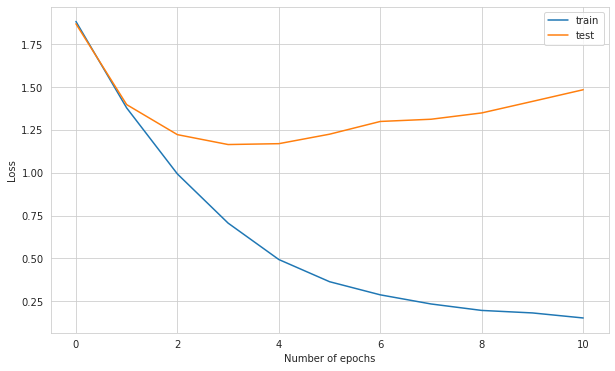

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

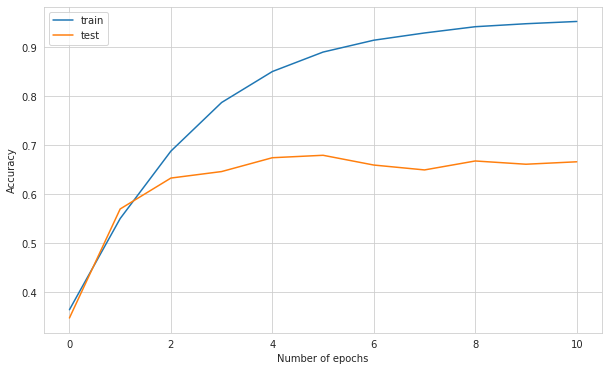

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show();

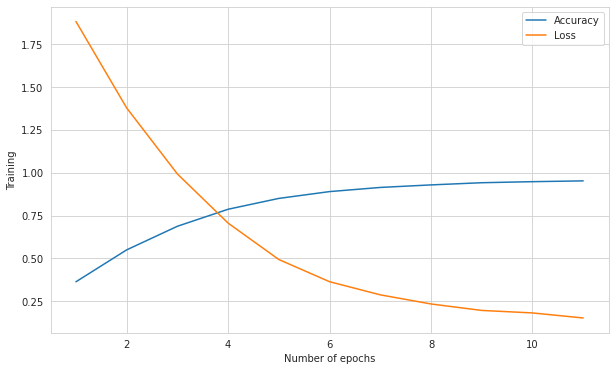

In [27]:
q = len(list(history.history['loss']))
plt.figure(figsize=(10, 6))
sns.lineplot(x = range(1, 1+q), y = history.history['accuracy'], label = 'Accuracy')
sns.lineplot(x = range(1, 1+q), y = history.history['loss'], label = 'Loss')
plt.xlabel('Number of epochs')
plt.ylabel('Training')
plt.legend();

In [32]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'lr'])


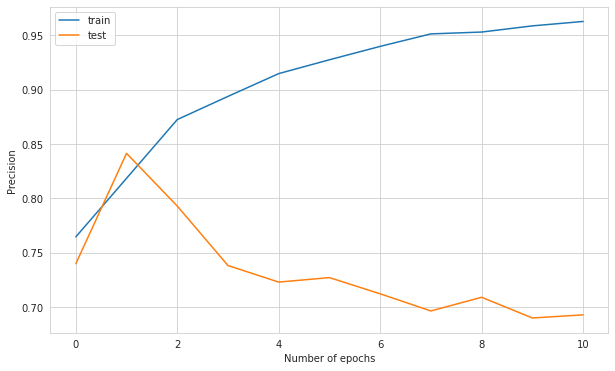

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['precision'], label='train')
plt.plot(history.history['val_precision'], label='test')
plt.xlabel('Number of epochs')
plt.ylabel('Precision')
plt.legend()
plt.show();

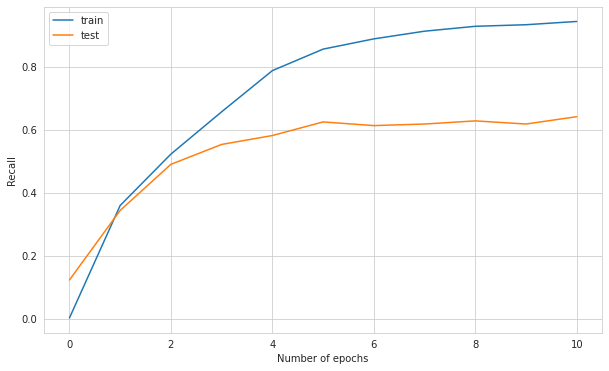

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['recall'], label='train')
plt.plot(history.history['val_recall'], label='test')
plt.xlabel('Number of epochs')
plt.ylabel('Recall')
plt.legend()
plt.show();

In [28]:
# Saving the model
model.save('drive/MyDrive/Multiclass Text Classification/LSTM_4.h5')